<a href="https://colab.research.google.com/github/shirsh008/reinforcement-learning-model-training/blob/main/simple_vrp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from gymnasium import spaces
from gymnasium.envs.registration import register
from enum import Enum

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class CustomEnvironment:
  def __init__(self, num_customers = 5, vehicle_capacity = 10):
    self.num_nodes = num_customers + 1
    self.vehicle_capacity = vehicle_capacity
    self.reset()

  def reset(self):
    self.locations = np.random.rand(self.num_nodes, 2)*100
    self.demands = np.random.randint(1,6, size = self.num_nodes)
    self.demands[0] = 0
    self.current_node = 0
    self.current_load = self.vehicle_capacity
    self.visited = [False] * self.num_nodes
    self.visited[0] = True
    self.nodes_visited = 0
    return self._get_state()

  def _get_state(self):
    return self.current_node, self.current_load, self.visited

  def calculate_distance(self, node_a, node_b):
    pos_a = self.locations[node_a]
    pos_b = self.locations[node_b]
    return np.linalg.norm(pos_a - pos_b)

  def step(self, action_node):
    if self.visited[action_node]:
      reward = -100
      return self._get_state(), reward, True

    if self.current_load < self.demands[action_node]:
      reward = -100
      self.visited[action_node] = True
      return self._get_state(), reward, True

    distance = self.calculate_distance(self.current_node, action_node)

    self.current_node = action_node
    self.current_load -= self.demands[action_node]
    self.visited[action_node] = True
    self.nodes_visited += 1

    reward = -distance
    reward += (self.demands[action_node] * 2)

    if self.nodes_visited == self.num_nodes-1:
      reward += 50
      done = True
    else:
      done = False

    return self._get_state(), reward, done

In [4]:
env = CustomEnvironment(num_customers = 5, vehicle_capacity = 20)

In [5]:
def preprocess_state(state, num_nodes, max_capacity):
  current_node, current_load, visited = state
  node_feat = np.zeros(num_nodes)
  node_feat[current_node] = 1.0

  load_feat = np.array([current_load / max_capacity])

  visited_feat = np.array(visited, dtype = np.float32)
  final_step = np.concatenate([node_feat, load_feat, visited])
  return torch.FloatTensor(final_step).unsqueeze(0).to(device)

In [6]:
class Policy(nn.Module):
  def __init__(self, num_nodes, h_size = 64):
    super(Policy, self).__init__()
    s_size = num_nodes + 1 + num_nodes
    a_size = num_nodes
    self.fc1 = nn.Linear(s_size,h_size)
    self.fc2 = nn.Linear(h_size,a_size)
    self.num_nodes = num_nodes

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

  def act(self, state, max_capacity):
    state_tensor = preprocess_state(state, self.num_nodes, max_capacity)
    probs = self.forward(state_tensor).cpu()
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
  scores_deque = deque(maxlen=100)
  scores = []
  for i_episodes in range(1, n_training_episodes+1):
    saved_log_probs = []
    rewards = []
    state = env.reset()
    for t in range(max_t):
      action, log_prob = policy.act(state, env.vehicle_capacity)
      saved_log_probs.append(log_prob)
      state, reward, done = env.step(action)
      rewards.append(reward)
      if done:
        break
    scores_deque.append(sum(rewards))
    scores.append(sum(rewards))

    returns = deque(maxlen=max_t)
    n_steps = len(rewards)

    for t in range(n_steps)[::-1]:
      disc_return_t = rewards[t] + (gamma * disc_return_t if t < n_steps-1 else 0)
      returns.appendleft(disc_return_t)

    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns, dtype=torch.float32)
    if len(returns) > 1:
      returns = (returns - returns.mean()) / (returns.std() + eps)
    else:
      returns = returns

    policy_loss = []
    for log_prob, disc_return in zip(saved_log_probs, returns):
      policy_loss.append(-log_prob * disc_return)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
  return scores

In [8]:
s_size = env.num_nodes + 1 + env.num_nodes
a_size = env.num_nodes
vrp_hyperparameters = {
    "h_size" : 64,
    "n_training_episodes" : 2000,
    "n_evaluation_episodes" : 10,
    "max_t" : 20,
    "gamma" : 1.0,
    "lr" : 1e-3,
    "state_space" : s_size,
    "action_space" : a_size,
}

In [9]:
vrp_policy = Policy(env.num_nodes, h_size=vrp_hyperparameters["h_size"]).to(device)
vrp_optimizer = optim.Adam(vrp_policy.parameters(), lr=vrp_hyperparameters["lr"])

In [10]:
scores = reinforce(vrp_policy,
                   vrp_optimizer,
                   vrp_hyperparameters["n_training_episodes"],
                   vrp_hyperparameters["max_t"],
                   vrp_hyperparameters["gamma"],
                   100)

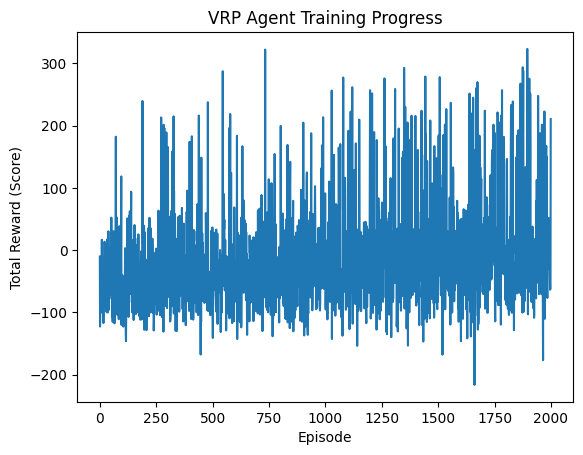

In [11]:
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Score)")
plt.title("VRP Agent Training Progress")
plt.show()

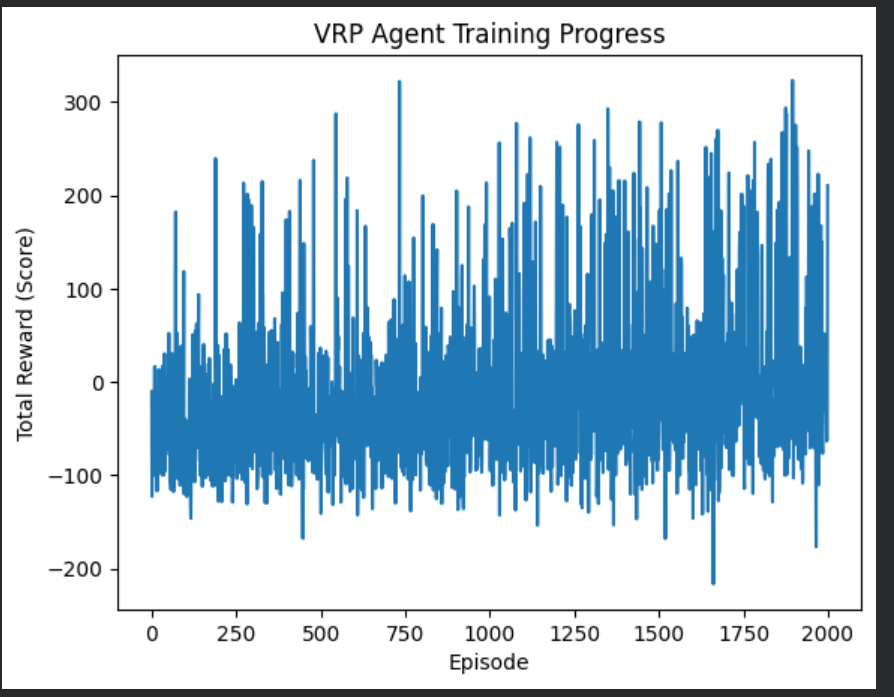

this was the image obtained if we change the reward from
reward = -distance to
reward = -distance + 70